In [1]:
from pathlib import Path
import os
import sys
import time
import pandas as pd
import modin.pandas as md
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
h5_path = os.path.join(notebook_dir,'alphaVantage vanillas.h5')
store = pd.HDFStore(h5_path)
store.close()

In [2]:
from historical_av_key_collector import keys_df
print(keys_df)

                            contract_key               raw_data_key  \
0     /date_2024_10_09/hottest_contracts  /date_2024_10_09/raw_data   
1     /date_2024_10_08/hottest_contracts  /date_2024_10_08/raw_data   
2     /date_2024_10_07/hottest_contracts  /date_2024_10_07/raw_data   
3     /date_2024_10_04/hottest_contracts  /date_2024_10_04/raw_data   
4     /date_2024_10_03/hottest_contracts  /date_2024_10_03/raw_data   
...                                  ...                        ...   
4195  /date_2008_01_08/hottest_contracts  /date_2008_01_08/raw_data   
4196  /date_2008_01_07/hottest_contracts  /date_2008_01_07/raw_data   
4197  /date_2008_01_04/hottest_contracts  /date_2008_01_04/raw_data   
4198  /date_2008_01_03/hottest_contracts  /date_2008_01_03/raw_data   
4199  /date_2008_01_02/hottest_contracts  /date_2008_01_02/raw_data   

                   surface_key               calibration_key  \
0     /date_2024_10_09/surface  /date_2024_10_09/calibration   
1     /date_2024_10

# historical time-series

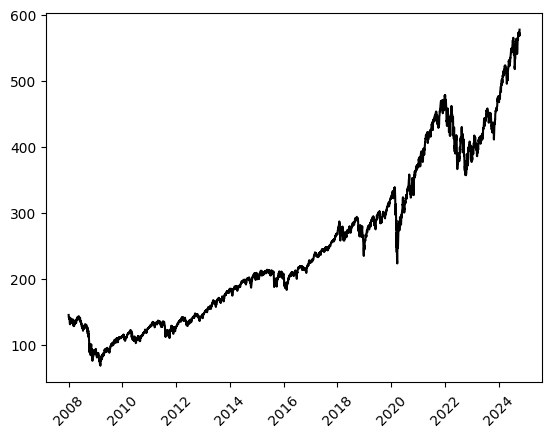

<Figure size 640x480 with 0 Axes>

In [3]:
contract_keys = keys_df.copy().dropna(subset='contract_key')
contracts = []
while True:
    try:
        store.open()
        for i,row in contract_keys.iterrows():
            contracts.append(store[row['contract_key']])
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()
contracts = pd.concat(contracts,ignore_index=True)[['date','spot_price']].drop_duplicates().set_index('date').squeeze()
plt.figure()
plt.plot(contracts,color='black')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# calibrations

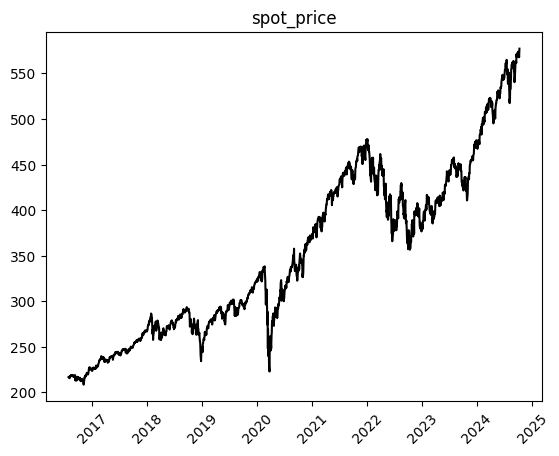

<Figure size 640x480 with 0 Axes>

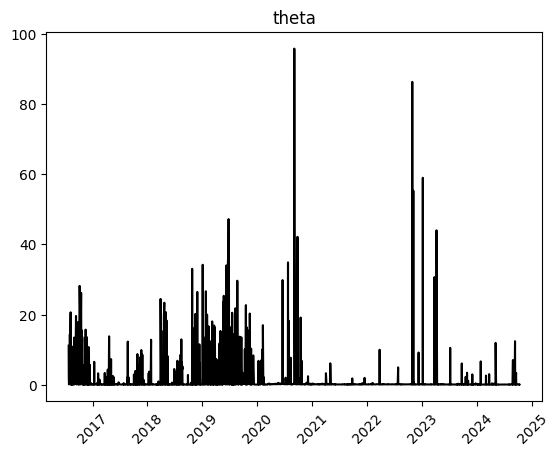

<Figure size 640x480 with 0 Axes>

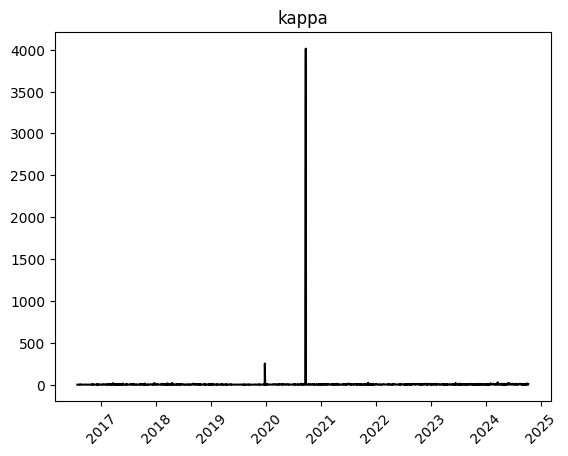

<Figure size 640x480 with 0 Axes>

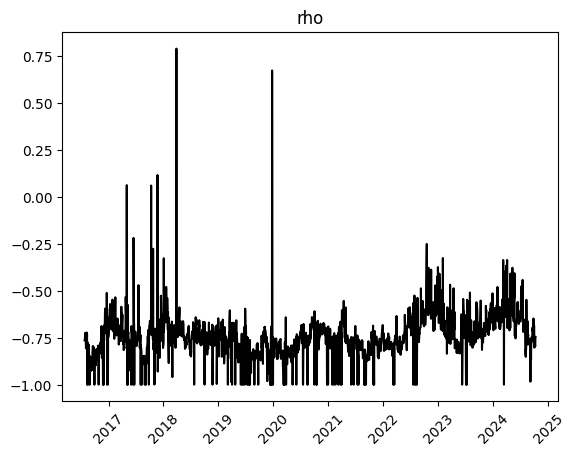

<Figure size 640x480 with 0 Axes>

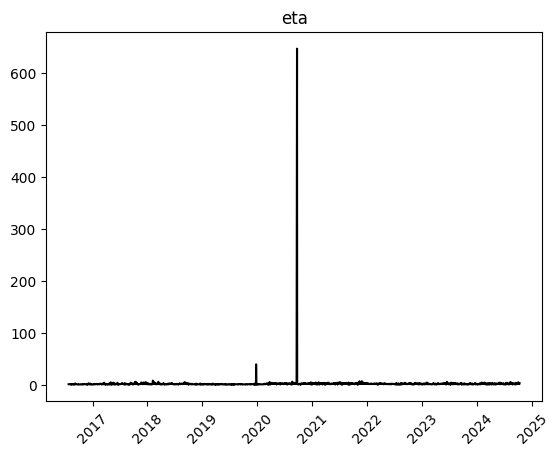

<Figure size 640x480 with 0 Axes>

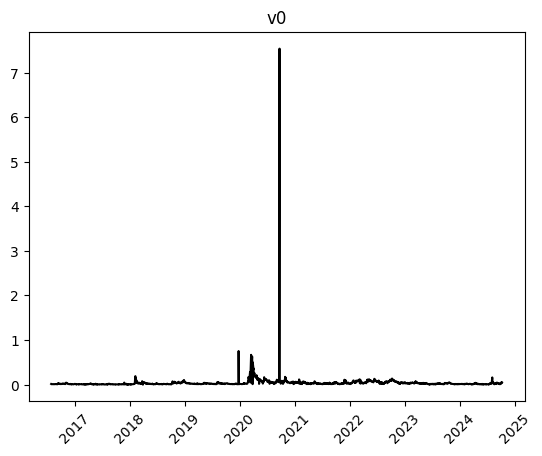


                    calculation_date   strike_price   market_price  \
count                        4469231 4469231.000000 4469231.000000   
mean   2021-01-30 06:50:51.783539712     339.439466      27.762628   
min              2016-07-26 00:00:00       5.000000       0.000000   
25%              2019-06-04 00:00:00     245.000000       0.260000   
50%              2021-04-05 00:00:00     327.000000       5.870000   
75%              2022-11-07 00:00:00     427.000000      31.500000   
max              2024-10-09 00:00:00    6400.000000     455.350000   
std                              NaN     129.160650      49.897535   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 4469231.000000    4469231.000000 4469231.000000  4469231.000000   
mean        0.261299        110.820853     369.981224        0.040000   
min         0.000130         30.000000     208.550000        0.040000   
25%         0.151690         50.000000     285.840000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [4]:
calibration_keys = keys_df.copy().dropna(subset='calibration_key')
calibrations = []
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True)
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()
for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

In [5]:
problem = calibrations.copy()[calibrations['rho']>0].reset_index()
problem_dates = problem['calculation_date']
problem_dates

0       2019-12-24
1       2019-12-24
2       2019-12-24
3       2019-12-24
4       2019-12-24
           ...    
10417   2017-05-02
10418   2017-05-02
10419   2017-05-02
10420   2017-05-02
10421   2017-05-02
Name: calculation_date, Length: 10422, dtype: datetime64[ns]

# computed prices

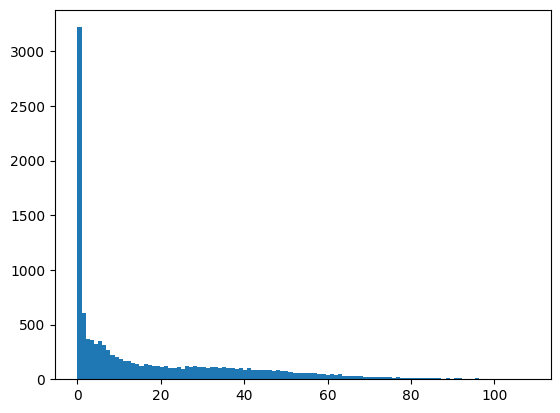

spot_price           float64
strike_price         float64
barrier              float64
days_to_maturity       int64
updown                object
outin                 object
w                     object
barrier_type_name     object
rebate               float64
dividend_rate        float64
risk_free_rate       float64
theta                float64
kappa                float64
rho                  float64
eta                  float64
v0                   float64
calculation_date      object
expiration_date       object
heston_vanilla       float64
barrier_price        float64
dtype: object
        spot_price  strike_price      barrier       rebate  dividend_rate  \
count 12000.000000  12000.000000 12000.000000 12000.000000   12000.000000   
mean    568.620000    568.620000   568.620000     0.000000       0.018000   
std       0.000000     33.493972   175.302346     0.000000       0.000000   
min     568.620000    511.758000   284.310000     0.000000       0.018000   
25%     568.620000   

<Figure size 640x480 with 0 Axes>

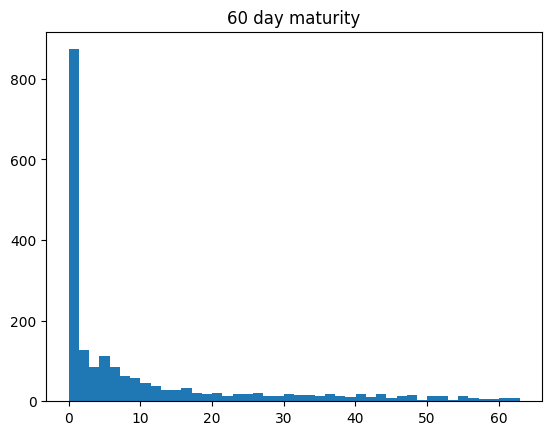

<Figure size 640x480 with 0 Axes>

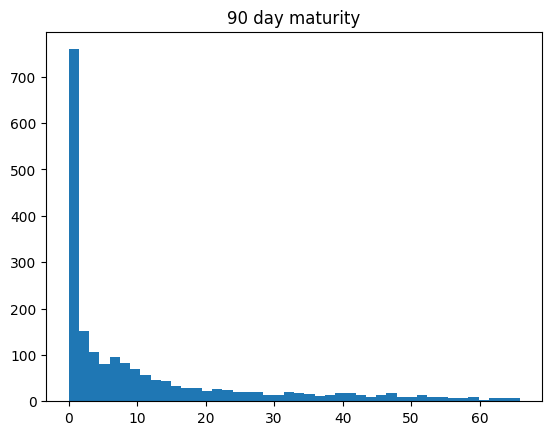

<Figure size 640x480 with 0 Axes>

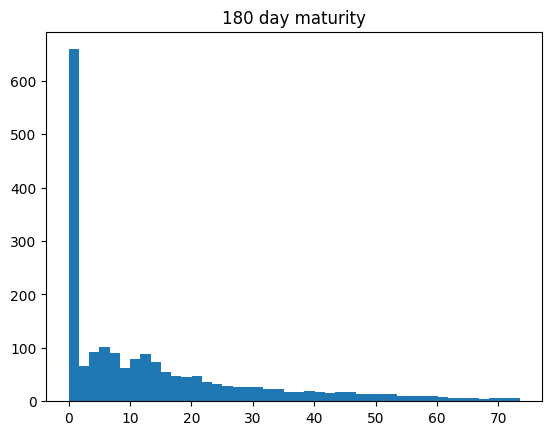

<Figure size 640x480 with 0 Axes>

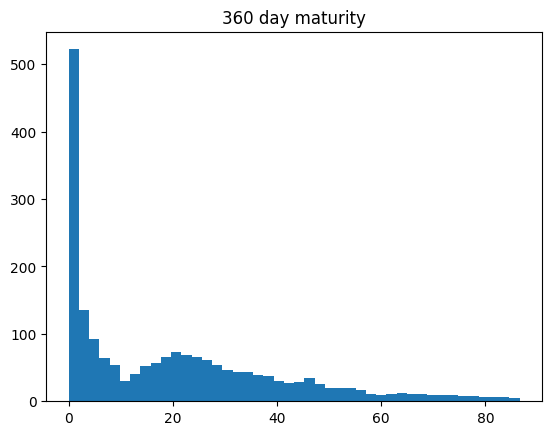

<Figure size 640x480 with 0 Axes>

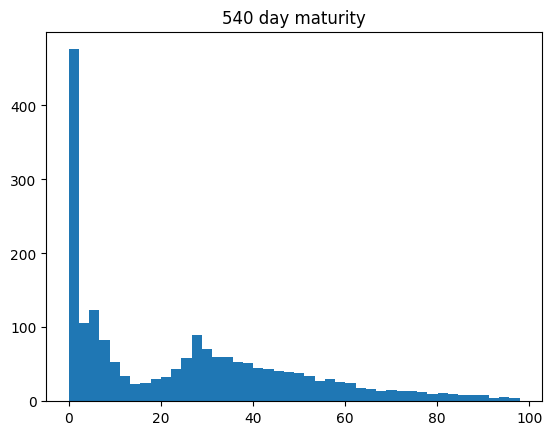

<Figure size 640x480 with 0 Axes>

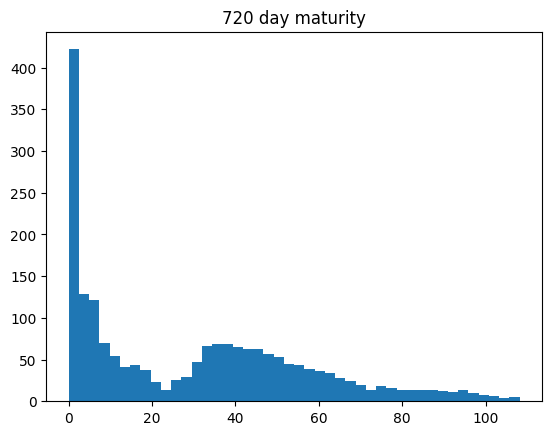

<Figure size 640x480 with 0 Axes>

In [14]:
prices_keys = keys_df.copy().dropna(subset='priced_securities_key')
while True:
    try:
        store.open()
        for i,row in prices_keys.iterrows():
            prices = store[row['priced_securities_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()
plt.figure()
plt.hist(prices['barrier_price'],bins=int(prices.shape[0]**0.5))
plt.show()
plt.clf()

print(prices.dtypes)

W = prices['w'].unique().tolist()
btypes = prices['barrier_type_name'].unique().tolist()
T = prices['days_to_maturity'].unique().tolist()
pricesby_t = prices.set_index('days_to_maturity')
print(pricesby_t.describe())

for t in T:
    price_series = pricesby_t.loc[t,'barrier_price']
    plt.figure()
    plt.hist(price_series,bins = int((price_series.shape[0])**0.5))
    plt.title(f"{t} day maturity")
    plt.show()
    plt.clf()

# calibration error testing

In [15]:
data=calibrations.copy()
problem_dates

0       2019-12-24
1       2019-12-24
2       2019-12-24
3       2019-12-24
4       2019-12-24
           ...    
10417   2017-05-02
10418   2017-05-02
10419   2017-05-02
10420   2017-05-02
10421   2017-05-02
Name: calculation_date, Length: 10422, dtype: datetime64[ns]

In [16]:
data = data[data.index.isin(problem_dates)]
data

,strike_price,w,market_price,volatility,days_to_maturity,spot_price,risk_free_rate,dividend_rate,theta,kappa,eta,rho,v0,moneyness,black_scholes,heston_price,relative_error
calculation_date,,,,,,,,,,,,,,,,,
2019-12-24,255.000000,call,0.000000,0.409610,31,321.230000,0.040000,0.018000,0.040800,252.271266,39.420670,0.675332,0.754071,0.259725,67.414248,66.609968,-0.011930
2019-12-24,255.000000,put,0.080000,0.329120,31,321.230000,0.040000,0.018000,0.040800,252.271266,39.420670,0.675332,0.754071,-0.206176,0.065443,0.005847,-0.910656
2019-12-24,260.000000,call,62.210000,0.382630,31,321.230000,0.040000,0.018000,0.040800,252.271266,39.420670,0.675332,0.754071,0.235500,62.442886,61.630613,-0.013008
2019-12-24,260.000000,put,0.110000,0.309460,31,321.230000,0.040000,0.018000,0.040800,252.271266,39.420670,0.675332,0.754071,-0.190611,0.074533,0.009535,-0.872068
2019-12-24,265.000000,call,0.000000,0.357320,31,321.230000,0.040000,0.018000,0.040800,252.271266,39.420670,0.675332,0.754071,0.212189,57.481023,56.653590,-0.014395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-02,325.000000,put,44.580000,0.268150,318,238.770000,0.040000,0.018000,0.047862,7.053470,4.695671,0.063880,0.011302,0.361143,79.845349,81.507192,0.020813
2017-05-02,330.000000,call,0.010000,0.111600,318,238.770000,0.040000,0.018000,0.047862,7.053470,4.695671,0.063880,0.011302,-0.276455,0.023996,2.553148,105.397128
2017-05-02,330.000000,put,0.000000,0.270130,318,238.770000,0.040000,0.018000,0.047862,7.053470,4.695671,0.063880,0.011302,0.382083,84.266558,86.196184,0.022899


In [18]:
print(keys_df)

                            contract_key               raw_data_key  \
0     /date_2024_10_09/hottest_contracts  /date_2024_10_09/raw_data   
1     /date_2024_10_08/hottest_contracts  /date_2024_10_08/raw_data   
2     /date_2024_10_07/hottest_contracts  /date_2024_10_07/raw_data   
3     /date_2024_10_04/hottest_contracts  /date_2024_10_04/raw_data   
4     /date_2024_10_03/hottest_contracts  /date_2024_10_03/raw_data   
...                                  ...                        ...   
4195  /date_2008_01_08/hottest_contracts  /date_2008_01_08/raw_data   
4196  /date_2008_01_07/hottest_contracts  /date_2008_01_07/raw_data   
4197  /date_2008_01_04/hottest_contracts  /date_2008_01_04/raw_data   
4198  /date_2008_01_03/hottest_contracts  /date_2008_01_03/raw_data   
4199  /date_2008_01_02/hottest_contracts  /date_2008_01_02/raw_data   

                   surface_key               calibration_key  \
0     /date_2024_10_09/surface  /date_2024_10_09/calibration   
1     /date_2024_10

In [23]:
problem_dates = pd.to_datetime(problem_dates)
problem_keys = keys_df[keys_df['date'].isin(problem_dates)]

,contract_key,raw_data_key,surface_key,calibration_key,priced_securities_key,extracted_date
1203,/date_2019_12_24/hottest_contracts,/date_2019_12_24/raw_data,/date_2019_12_24/surface,/date_2019_12_24/calibration,NaN,2019-12-24
1630,/date_2018_03_28/hottest_contracts,/date_2018_03_28/raw_data,/date_2018_03_28/surface,/date_2018_03_28/calibration,NaN,2018-03-28
1715,/date_2017_11_22/hottest_contracts,/date_2017_11_22/raw_data,/date_2017_11_22/surface,/date_2017_11_22/calibration,NaN,2017-11-22
1745,/date_2017_10_11/hottest_contracts,/date_2017_10_11/raw_data,/date_2017_10_11/surface,/date_2017_10_11/calibration,NaN,2017-10-11
1858,/date_2017_05_02/hottest_contracts,/date_2017_05_02/raw_data,/date_2017_05_02/surface,/date_2017_05_02/calibration,NaN,2017-05-02
